In [1]:
from kfp import dsl
from kfp.dsl import (Artifact,
                        Dataset,
                        Input,
                        Model,
                        Output,
                        Metrics,
                        ClassificationMetrics,
                        component)

from kfp import compiler

# Workload Test

In [2]:
# Configuration
dir_dataset="../raw_data"
dir_model="../models"
dir_evaluation="../evaluation"
dir_compiled_pipeline="../compiled-pipeline"
file_train_data="train_breast_cancer.csv"
file_test_data="test_breast_cancer.csv"
file_model="model_xgboost_breast_cancer.bst"
file_compiled_pipeline="pipeline_xgboost_breast_cancer.json"
file_pipeline_name="pipeline_xgboost_breast_cancer-handson"
config_pipeline_root="gs://storied-bearing-407115-bucket"

In [3]:
# Data Extraction
from sklearn import datasets
from sklearn.model_selection import train_test_split as tts
import pandas as pd

data_raw = datasets.load_breast_cancer()
data = pd.DataFrame(data_raw.data, columns=data_raw.feature_names)
data["target"] = data_raw.target

train, test = tts(data, test_size=0.3)
train.to_csv(dir_dataset+"/"+file_train_data)
test.to_csv(dir_dataset+"/"+file_test_data)

In [4]:
# Model Training

from xgboost import XGBClassifier
import pandas as pd

data = pd.read_csv(dir_dataset+"/"+file_train_data)

model = XGBClassifier(
    objective="binary:logistic"
)
model.fit(
    data.drop(columns=["target"]),
    data.target,
)

score = model.score(
    data.drop(columns=["target"]),
    data.target,
)

model.save_model(dir_model+"/"+file_model)

/opt/homebrew/Caskroom/miniforge/base/envs/kfp-compiler/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:52:50] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Model Accuracy: 0.9707602339181286


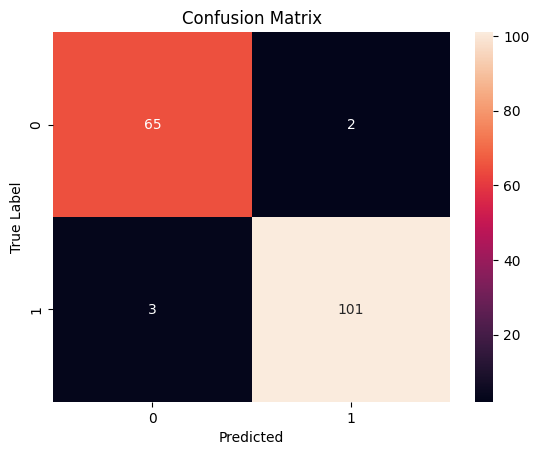

In [5]:
# Model Evaluation
from xgboost import XGBClassifier
import pandas as pd
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv(dir_dataset+"/"+file_test_data)
model = XGBClassifier()
model.load_model(dir_model+"/"+file_model)


# Calculate the accuracy
accuracy = model.score(
    data.drop(columns=["target"]),
    data.target,
)

# Print the accuracy
print(f"Model Accuracy: {accuracy}")

# Confusion Matrix 생성
predictions = model.predict(data.drop(columns=["target"]))
cm = confusion_matrix(test.target, predictions)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
plt.savefig(dir_evaluation+"/"+"confusion_matrix.png")

# # Feature Importance 추출
# feature_importances = model.feature_importances_
# feature_names = (list(data.columns))[1:-1]

# # 시각화
# plt.barh(range(len(feature_importances)), feature_importances)
# plt.yticks(range(len(feature_names)), feature_names)
# plt.xlabel('Feature Importance')
# plt.title('Feature Importance')
# plt.show()

# Pipeline Components

## Data Extraction

In [6]:
@component(
    packages_to_install = [
        "pandas",
        "scikit-learn"
    ],
    base_image="python:3.9.18-slim"
)
def get_data(
    dataset_train: Output[Dataset],
    dataset_test: Output[Dataset]
    
):
    
    from sklearn import datasets
    from sklearn.model_selection import train_test_split as tts
    import pandas as pd
    # import some data to play with
    
    data_raw = datasets.load_breast_cancer()
    data = pd.DataFrame(data_raw.data, columns=data_raw.feature_names)
    data["target"] = data_raw.target
    
    train, test = tts(data, test_size=0.3)
    
    train.to_csv(dataset_train.path)
    test.to_csv(dataset_test.path)

## Model Training

In [7]:
@component(
    packages_to_install = [
        "pandas",
        "scikit-learn",
        "xgboost"
    ],
    base_image="python:3.9.18-slim"
)
def train_xgb_model(
    dataset: Input[Dataset],
    model_artifact: Output[Model]
):
    
    from xgboost import XGBClassifier
    import pandas as pd
    
    data = pd.read_csv(dataset.path)

    model = XGBClassifier(
        objective="binary:logistic"
    )
    model.fit(
        data.drop(columns=["target"]),
        data.target,
    )

    score = model.score(
        data.drop(columns=["target"]),
        data.target,
    )

    model_artifact.metadata["train_score"] = float(score)
    model_artifact.metadata["framework"] = "XGBoost"
    
    model.save_model(model_artifact.path)

## Model Evaluation

In [8]:
@component(
    packages_to_install = [
        "pandas",
        "scikit-learn",
        "xgboost"
    ],
    base_image="python:3.9.18-slim"
)
def eval_model(
    test_set: Input[Dataset],
    xgb_model: Input[Model],
    smetrics: Output[Metrics],  # Only output for simple metrics
    metrics: Output[ClassificationMetrics]  # Only output for classification metrics
):
    from xgboost import XGBClassifier
    import pandas as pd
    from sklearn.metrics import confusion_matrix, classification_report

    # Load the test dataset
    data = pd.read_csv(test_set.path)

    # Load the XGBoost model
    model = XGBClassifier()
    model.load_model(xgb_model.path)

    # Calculate the accuracy of the model
    accuracy = model.score(data.drop(columns=["target"]), data["target"])

    # Log the accuracy in the metrics
    smetrics.log_metric("accuracy", float(accuracy))

    # Optionally, store accuracy in model's metadata (if needed)
    xgb_model.metadata["test_accuracy"] = float(accuracy)
    
    # create confusion metrix and store in 'metrics' variable
    predictions = model.predict(data.drop(columns=["target"]))
    cm = confusion_matrix(data.target, predictions)
    metrics.log_confusion_matrix(
        ["malignant", "benign"],
        cm.tolist()
    )


In [9]:
@dsl.pipeline(
    # Default pipeline root. You can override it when submitting the pipeline.
    pipeline_root=config_pipeline_root,
    # A name for the pipeline. Use to determine the pipeline Context.
    name=file_pipeline_name,
)
def pipeline():
    dataset_op = get_data()
    train_op = train_xgb_model(dataset=dataset_op.outputs["dataset_train"])
    eval_op = eval_model(
        test_set=dataset_op.outputs["dataset_test"],
        xgb_model=train_op.outputs["model_artifact"]
    )
    
compiler.Compiler().compile(pipeline_func=pipeline,
        package_path=f"{dir_compiled_pipeline}/{file_compiled_pipeline}")